In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/kaggle_histo/train/'
validation_dir = 'data/kaggle_histo/validation/'
test_dir = "data/kaggle_histo/test/"

extracted_features_dir = "extracted_features/"
model_name = "kaggle_histo_3path_CNN"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/kaggle_histo/train/ 0
data/kaggle_histo/train/cancer 256400
data/kaggle_histo/train/normal 375900
******************************
data/kaggle_histo/test/ 0
data/kaggle_histo/test/cancer 6368
data/kaggle_histo/test/normal 9376


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
#     validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 632300 images belonging to 2 classes.
Found 184732 images belonging to 2 classes.
Found 15744 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 632300
nb_validation_samples: 184732

predict_size_train: 19760
predict_size_validation: 5773
nb_test_samples: 15744
predict_size_test: 492

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  

base_model1=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=MobileNetV2(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

merge = concatenate([x1, x2, x3])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
c1 = model.layers[7].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[53].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[141].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[481].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[827].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[835].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[851].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[866].output
c8 = GlobalAveragePooling2D()(c8) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [9]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [10]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 632300 samples, validate on 184732 samples
Epoch 1/1000
 - 74s - loss: 0.3640 - acc: 0.8396 - val_loss: 0.3167 - val_acc: 0.8615
Epoch 2/1000
 - 69s - loss: 0.3180 - acc: 0.8635 - val_loss: 0.2931 - val_acc: 0.8747
Epoch 3/1000
 - 69s - loss: 0.3020 - acc: 0.8715 - val_loss: 0.3113 - val_acc: 0.8663
Epoch 4/1000
 - 70s - loss: 0.2914 - acc: 0.8774 - val_loss: 0.2702 - val_acc: 0.8858
Epoch 5/1000
 - 70s - loss: 0.2844 - acc: 0.8810 - val_loss: 0.2681 - val_acc: 0.8888
Epoch 6/1000
 - 69s - loss: 0.2788 - acc: 0.8838 - val_loss: 0.3005 - val_acc: 0.8708
Epoch 7/1000
 - 69s - loss: 0.2741 - acc: 0.8862 - val_loss: 0.2584 - val_acc: 0.8921
Epoch 8/1000
 - 69s - loss: 0.2706 - acc: 0.8879 - val_loss: 0.2511 - val_acc: 0.8949
Epoch 9/1000
 - 69s - loss: 0.2675 - acc: 0.8896 - val_loss: 0.2581 - val_acc: 0.8918
Epoch 10/1000
 - 70s - loss: 0.2641 - acc: 0.8910 - val_loss: 0.2623 - val_acc: 0.8881
Epoch 11/1000
 - 69s - loss: 0.2614 - acc: 0.8924 - val_loss: 0.2493 - val_acc: 0.8967


Epoch 95/1000
 - 70s - loss: 0.2037 - acc: 0.9194 - val_loss: 0.1939 - val_acc: 0.9224
Epoch 96/1000
 - 70s - loss: 0.2026 - acc: 0.9199 - val_loss: 0.1892 - val_acc: 0.9264
Epoch 97/1000
 - 70s - loss: 0.2025 - acc: 0.9201 - val_loss: 0.1908 - val_acc: 0.9240
Epoch 98/1000
 - 70s - loss: 0.2023 - acc: 0.9201 - val_loss: 0.1901 - val_acc: 0.9249
Epoch 99/1000
 - 70s - loss: 0.2020 - acc: 0.9202 - val_loss: 0.2040 - val_acc: 0.9182
Epoch 100/1000
 - 70s - loss: 0.2020 - acc: 0.9201 - val_loss: 0.1926 - val_acc: 0.9243
Epoch 101/1000
 - 70s - loss: 0.2009 - acc: 0.9206 - val_loss: 0.1929 - val_acc: 0.9235
Epoch 102/1000
 - 70s - loss: 0.2013 - acc: 0.9205 - val_loss: 0.1957 - val_acc: 0.9218
Epoch 103/1000
 - 70s - loss: 0.2015 - acc: 0.9205 - val_loss: 0.1931 - val_acc: 0.9249
Epoch 104/1000
 - 70s - loss: 0.2009 - acc: 0.9205 - val_loss: 0.1915 - val_acc: 0.9231
Epoch 105/1000
 - 70s - loss: 0.2006 - acc: 0.9208 - val_loss: 0.1876 - val_acc: 0.9257
Epoch 106/1000
 - 70s - loss: 0.2001 

 - 70s - loss: 0.1845 - acc: 0.9275 - val_loss: 0.1733 - val_acc: 0.9327
Epoch 189/1000
 - 70s - loss: 0.1847 - acc: 0.9277 - val_loss: 0.1819 - val_acc: 0.9285
Epoch 190/1000
 - 70s - loss: 0.1847 - acc: 0.9275 - val_loss: 0.1771 - val_acc: 0.9308
Epoch 191/1000
 - 70s - loss: 0.1839 - acc: 0.9279 - val_loss: 0.1795 - val_acc: 0.9288
Epoch 192/1000
 - 70s - loss: 0.1841 - acc: 0.9281 - val_loss: 0.1759 - val_acc: 0.9312
Epoch 193/1000
 - 70s - loss: 0.1843 - acc: 0.9278 - val_loss: 0.1759 - val_acc: 0.9308
Epoch 194/1000
 - 70s - loss: 0.1844 - acc: 0.9279 - val_loss: 0.1771 - val_acc: 0.9308
Epoch 195/1000
 - 70s - loss: 0.1839 - acc: 0.9282 - val_loss: 0.1754 - val_acc: 0.9311
Epoch 196/1000
 - 70s - loss: 0.1835 - acc: 0.9281 - val_loss: 0.1776 - val_acc: 0.9318
Epoch 197/1000
 - 70s - loss: 0.1837 - acc: 0.9283 - val_loss: 0.1739 - val_acc: 0.9322
Epoch 198/1000
 - 70s - loss: 0.1838 - acc: 0.9284 - val_loss: 0.1749 - val_acc: 0.9318
Epoch 199/1000
 - 70s - loss: 0.1834 - acc: 0.9

Epoch 282/1000
 - 70s - loss: 0.1742 - acc: 0.9323 - val_loss: 0.1733 - val_acc: 0.9340
Epoch 283/1000
 - 70s - loss: 0.1740 - acc: 0.9322 - val_loss: 0.1677 - val_acc: 0.9343
Epoch 284/1000
 - 70s - loss: 0.1739 - acc: 0.9326 - val_loss: 0.1671 - val_acc: 0.9362
Epoch 285/1000
 - 70s - loss: 0.1738 - acc: 0.9324 - val_loss: 0.1791 - val_acc: 0.9300
Epoch 286/1000
 - 70s - loss: 0.1737 - acc: 0.9326 - val_loss: 0.1699 - val_acc: 0.9344
Epoch 287/1000
 - 70s - loss: 0.1729 - acc: 0.9326 - val_loss: 0.1683 - val_acc: 0.9348
Epoch 288/1000
 - 70s - loss: 0.1732 - acc: 0.9326 - val_loss: 0.1751 - val_acc: 0.9317
Epoch 289/1000
 - 70s - loss: 0.1738 - acc: 0.9324 - val_loss: 0.1673 - val_acc: 0.9358
Epoch 290/1000
 - 70s - loss: 0.1733 - acc: 0.9328 - val_loss: 0.1662 - val_acc: 0.9366
Epoch 291/1000
 - 70s - loss: 0.1732 - acc: 0.9330 - val_loss: 0.1731 - val_acc: 0.9338
Epoch 292/1000
 - 70s - loss: 0.1733 - acc: 0.9325 - val_loss: 0.1683 - val_acc: 0.9345
Epoch 293/1000
 - 70s - loss: 0.

 - 70s - loss: 0.1657 - acc: 0.9359 - val_loss: 0.1641 - val_acc: 0.9371
Epoch 376/1000
 - 70s - loss: 0.1663 - acc: 0.9357 - val_loss: 0.1653 - val_acc: 0.9361
Epoch 377/1000
 - 70s - loss: 0.1660 - acc: 0.9356 - val_loss: 0.1634 - val_acc: 0.9372
Epoch 378/1000
 - 70s - loss: 0.1655 - acc: 0.9353 - val_loss: 0.1619 - val_acc: 0.9379
Epoch 379/1000
 - 70s - loss: 0.1659 - acc: 0.9354 - val_loss: 0.1614 - val_acc: 0.9388
Epoch 380/1000
 - 70s - loss: 0.1654 - acc: 0.9360 - val_loss: 0.1635 - val_acc: 0.9381
Epoch 381/1000
 - 70s - loss: 0.1659 - acc: 0.9356 - val_loss: 0.1601 - val_acc: 0.9387
Epoch 382/1000
 - 70s - loss: 0.1651 - acc: 0.9358 - val_loss: 0.1595 - val_acc: 0.9391
Epoch 383/1000
 - 70s - loss: 0.1651 - acc: 0.9358 - val_loss: 0.1596 - val_acc: 0.9395
Epoch 384/1000
 - 70s - loss: 0.1652 - acc: 0.9358 - val_loss: 0.1607 - val_acc: 0.9388
Epoch 385/1000
 - 70s - loss: 0.1654 - acc: 0.9357 - val_loss: 0.1601 - val_acc: 0.9393
Epoch 386/1000
 - 70s - loss: 0.1650 - acc: 0.9

Epoch 469/1000
 - 70s - loss: 0.1602 - acc: 0.9382 - val_loss: 0.1593 - val_acc: 0.9397
Epoch 470/1000
 - 70s - loss: 0.1607 - acc: 0.9379 - val_loss: 0.1611 - val_acc: 0.9394
Epoch 471/1000
 - 70s - loss: 0.1601 - acc: 0.9379 - val_loss: 0.1583 - val_acc: 0.9395
Epoch 472/1000
 - 70s - loss: 0.1600 - acc: 0.9383 - val_loss: 0.1605 - val_acc: 0.9379
Epoch 473/1000
 - 70s - loss: 0.1593 - acc: 0.9383 - val_loss: 0.1569 - val_acc: 0.9398
Epoch 474/1000
 - 70s - loss: 0.1591 - acc: 0.9386 - val_loss: 0.1597 - val_acc: 0.9394
Epoch 475/1000
 - 70s - loss: 0.1598 - acc: 0.9382 - val_loss: 0.1557 - val_acc: 0.9410
Epoch 476/1000
 - 70s - loss: 0.1598 - acc: 0.9384 - val_loss: 0.1601 - val_acc: 0.9392
Epoch 477/1000
 - 70s - loss: 0.1597 - acc: 0.9380 - val_loss: 0.1579 - val_acc: 0.9398
Epoch 478/1000
 - 70s - loss: 0.1592 - acc: 0.9384 - val_loss: 0.1614 - val_acc: 0.9388
Epoch 479/1000
 - 70s - loss: 0.1600 - acc: 0.9380 - val_loss: 0.1579 - val_acc: 0.9399
Epoch 480/1000
 - 70s - loss: 0.

 - 70s - loss: 0.1551 - acc: 0.9401 - val_loss: 0.1563 - val_acc: 0.9415
Epoch 563/1000
 - 70s - loss: 0.1555 - acc: 0.9397 - val_loss: 0.1544 - val_acc: 0.9415
Epoch 564/1000
 - 70s - loss: 0.1544 - acc: 0.9402 - val_loss: 0.1578 - val_acc: 0.9407
Epoch 565/1000
 - 70s - loss: 0.1553 - acc: 0.9398 - val_loss: 0.1569 - val_acc: 0.9416
Epoch 566/1000
 - 70s - loss: 0.1551 - acc: 0.9400 - val_loss: 0.1560 - val_acc: 0.9410
Epoch 567/1000
 - 70s - loss: 0.1548 - acc: 0.9399 - val_loss: 0.1528 - val_acc: 0.9424
Epoch 568/1000
 - 70s - loss: 0.1552 - acc: 0.9399 - val_loss: 0.1561 - val_acc: 0.9409
Epoch 569/1000
 - 70s - loss: 0.1551 - acc: 0.9399 - val_loss: 0.1561 - val_acc: 0.9405
Epoch 570/1000
 - 70s - loss: 0.1544 - acc: 0.9403 - val_loss: 0.1593 - val_acc: 0.9393
Epoch 571/1000
 - 70s - loss: 0.1542 - acc: 0.9404 - val_loss: 0.1554 - val_acc: 0.9420
Epoch 572/1000
 - 70s - loss: 0.1543 - acc: 0.9400 - val_loss: 0.1572 - val_acc: 0.9402
Epoch 573/1000
 - 70s - loss: 0.1545 - acc: 0.9

Epoch 656/1000
 - 70s - loss: 0.1507 - acc: 0.9418 - val_loss: 0.1567 - val_acc: 0.9408
Epoch 657/1000
 - 70s - loss: 0.1506 - acc: 0.9419 - val_loss: 0.1526 - val_acc: 0.9431
Epoch 658/1000
 - 70s - loss: 0.1506 - acc: 0.9416 - val_loss: 0.1528 - val_acc: 0.9427
Epoch 659/1000
 - 70s - loss: 0.1505 - acc: 0.9419 - val_loss: 0.1537 - val_acc: 0.9415
Epoch 660/1000
 - 70s - loss: 0.1506 - acc: 0.9416 - val_loss: 0.1540 - val_acc: 0.9419
Epoch 661/1000
 - 70s - loss: 0.1505 - acc: 0.9419 - val_loss: 0.1514 - val_acc: 0.9431
Epoch 662/1000
 - 70s - loss: 0.1507 - acc: 0.9417 - val_loss: 0.1520 - val_acc: 0.9425
Epoch 663/1000
 - 70s - loss: 0.1503 - acc: 0.9419 - val_loss: 0.1548 - val_acc: 0.9428
Epoch 664/1000
 - 70s - loss: 0.1511 - acc: 0.9415 - val_loss: 0.1526 - val_acc: 0.9424
Epoch 665/1000
 - 70s - loss: 0.1507 - acc: 0.9416 - val_loss: 0.1540 - val_acc: 0.9415
Epoch 666/1000
 - 70s - loss: 0.1503 - acc: 0.9421 - val_loss: 0.1579 - val_acc: 0.9411
Epoch 667/1000
 - 70s - loss: 0.

 - 70s - loss: 0.1473 - acc: 0.9427 - val_loss: 0.1616 - val_acc: 0.9385
Epoch 750/1000
 - 70s - loss: 0.1474 - acc: 0.9430 - val_loss: 0.1529 - val_acc: 0.9430
Epoch 751/1000
 - 70s - loss: 0.1471 - acc: 0.9434 - val_loss: 0.1553 - val_acc: 0.9428
Epoch 752/1000
 - 70s - loss: 0.1473 - acc: 0.9430 - val_loss: 0.1552 - val_acc: 0.9424
Epoch 753/1000
 - 70s - loss: 0.1477 - acc: 0.9428 - val_loss: 0.1522 - val_acc: 0.9436
Epoch 754/1000
 - 70s - loss: 0.1472 - acc: 0.9431 - val_loss: 0.1489 - val_acc: 0.9441
Epoch 755/1000
 - 70s - loss: 0.1464 - acc: 0.9430 - val_loss: 0.1524 - val_acc: 0.9419
Epoch 756/1000
 - 70s - loss: 0.1471 - acc: 0.9431 - val_loss: 0.1558 - val_acc: 0.9436
Epoch 757/1000
 - 70s - loss: 0.1473 - acc: 0.9431 - val_loss: 0.1528 - val_acc: 0.9425
Epoch 758/1000
 - 70s - loss: 0.1471 - acc: 0.9432 - val_loss: 0.1514 - val_acc: 0.9434
Epoch 759/1000
 - 70s - loss: 0.1469 - acc: 0.9431 - val_loss: 0.1560 - val_acc: 0.9416
Epoch 760/1000
 - 70s - loss: 0.1471 - acc: 0.9

Epoch 843/1000
 - 70s - loss: 0.1441 - acc: 0.9444 - val_loss: 0.1526 - val_acc: 0.9419
Epoch 844/1000
 - 69s - loss: 0.1444 - acc: 0.9442 - val_loss: 0.1533 - val_acc: 0.9436
Epoch 845/1000
 - 69s - loss: 0.1436 - acc: 0.9446 - val_loss: 0.1552 - val_acc: 0.9424
Epoch 846/1000
 - 69s - loss: 0.1440 - acc: 0.9444 - val_loss: 0.1523 - val_acc: 0.9429
Epoch 847/1000
 - 70s - loss: 0.1441 - acc: 0.9444 - val_loss: 0.1482 - val_acc: 0.9443
Epoch 848/1000
 - 69s - loss: 0.1441 - acc: 0.9439 - val_loss: 0.1509 - val_acc: 0.9445
Epoch 849/1000
 - 69s - loss: 0.1436 - acc: 0.9445 - val_loss: 0.1519 - val_acc: 0.9436
Epoch 850/1000
 - 69s - loss: 0.1439 - acc: 0.9443 - val_loss: 0.1473 - val_acc: 0.9447
Epoch 851/1000
 - 70s - loss: 0.1444 - acc: 0.9441 - val_loss: 0.1494 - val_acc: 0.9446
Epoch 852/1000
 - 69s - loss: 0.1433 - acc: 0.9444 - val_loss: 0.1524 - val_acc: 0.9432
Epoch 853/1000
 - 70s - loss: 0.1437 - acc: 0.9445 - val_loss: 0.1490 - val_acc: 0.9443
Epoch 854/1000
 - 69s - loss: 0.

 - 69s - loss: 0.1411 - acc: 0.9454 - val_loss: 0.1549 - val_acc: 0.9425
Epoch 937/1000
 - 69s - loss: 0.1410 - acc: 0.9452 - val_loss: 0.1507 - val_acc: 0.9437
Epoch 938/1000
 - 69s - loss: 0.1412 - acc: 0.9455 - val_loss: 0.1534 - val_acc: 0.9426
Epoch 939/1000
 - 69s - loss: 0.1412 - acc: 0.9452 - val_loss: 0.1521 - val_acc: 0.9430
Epoch 940/1000
 - 69s - loss: 0.1405 - acc: 0.9458 - val_loss: 0.1490 - val_acc: 0.9441
Epoch 941/1000
 - 70s - loss: 0.1414 - acc: 0.9456 - val_loss: 0.1526 - val_acc: 0.9437
Epoch 942/1000
 - 69s - loss: 0.1410 - acc: 0.9459 - val_loss: 0.1486 - val_acc: 0.9443
Epoch 943/1000
 - 69s - loss: 0.1410 - acc: 0.9457 - val_loss: 0.1489 - val_acc: 0.9450
Epoch 944/1000
 - 69s - loss: 0.1409 - acc: 0.9457 - val_loss: 0.1497 - val_acc: 0.9446
Epoch 945/1000
 - 69s - loss: 0.1409 - acc: 0.9455 - val_loss: 0.1527 - val_acc: 0.9435
Epoch 946/1000
 - 70s - loss: 0.1406 - acc: 0.9455 - val_loss: 0.1507 - val_acc: 0.9439
Epoch 947/1000
 - 69s - loss: 0.1410 - acc: 0.9

In [11]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9463922764227642


Confusion Matrix
[[5967  401]
 [ 443 8933]]


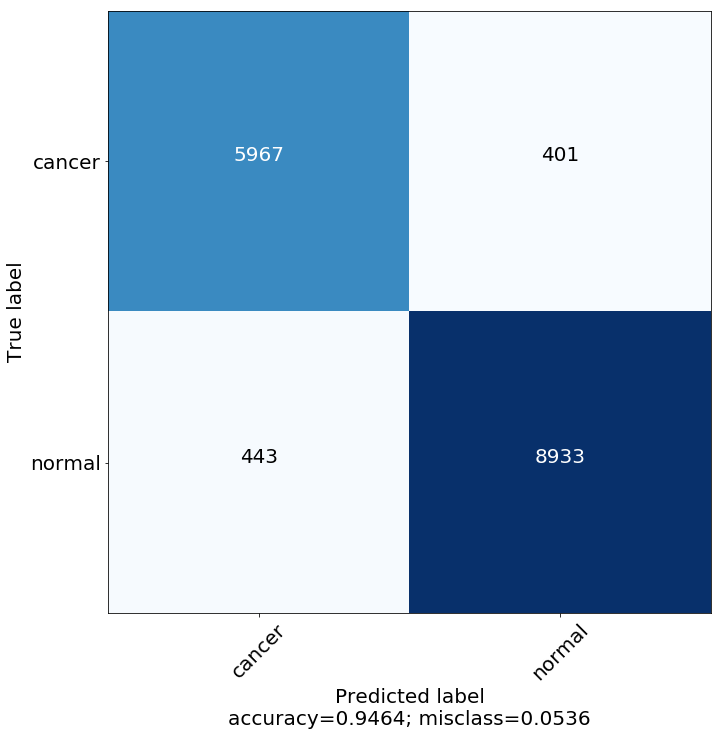

In [12]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[5967  401]
 [ 443 8933]]
              precision    recall  f1-score   support

      normal       0.93      0.94      0.93      6368
      cancer       0.96      0.95      0.95      9376

   micro avg       0.95      0.95      0.95     15744
   macro avg       0.94      0.94      0.94     15744
weighted avg       0.95      0.95      0.95     15744



In [14]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  93.08892355694228
Specificity :  95.70387829440755


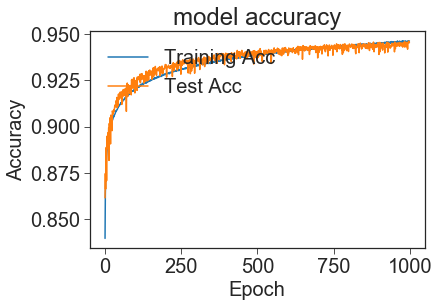

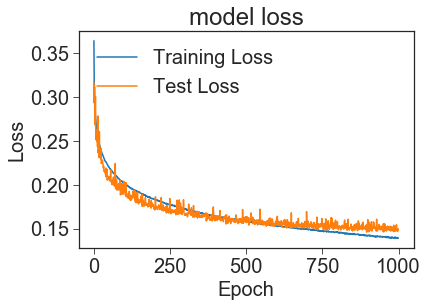

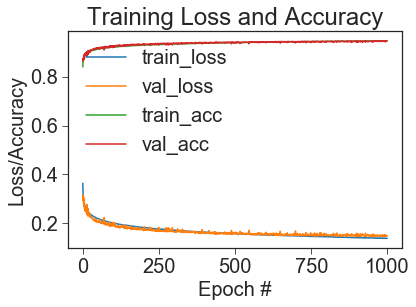

In [15]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [16]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9439640092567492


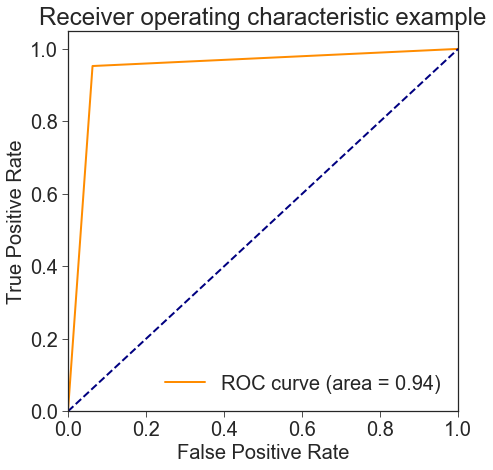

In [17]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [18]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

15744/15744 [==============================] - 0s 27us/step


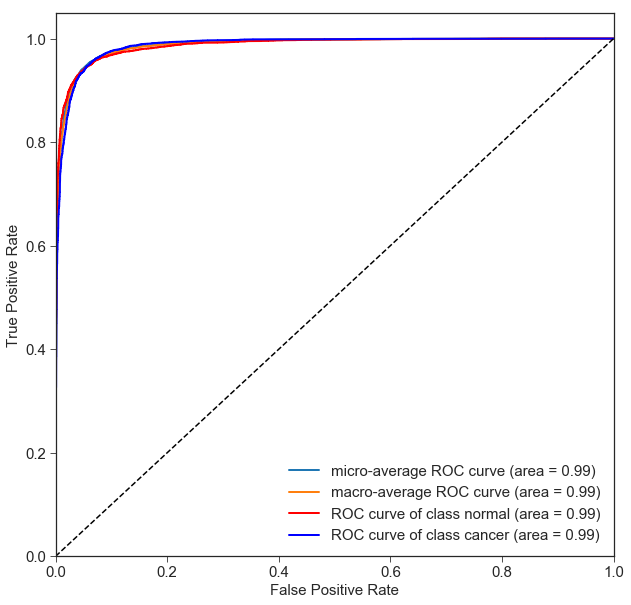

In [19]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [20]:
tn, fp, fn, tp = cm.ravel()

print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.9463922764227642
Precision: 0.9570387829440754
Recall: 0.9527517064846417
tp: 8933
fp: 401
tn: 5967
fn: 443


In [21]:
print('F1 score:', f1_score(y_true, y_pred))

recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9548904329235702
F1 score: 0.9548904329235702
